<a href="https://colab.research.google.com/github/aviMitra/EVA5/blob/main/Assignment%203x%20Runs/EVA_Assignment3x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Assignment 3x: EMNIST Neural Network 

Make a network that has:
<ul>
<li>6 Convolution layers with these kernels (10, 10, 20, 20, 30)
<li>no fully connected layer (you probably may have to use the Global Average Pooling layer)
<li>uses EMNIST as the dataset
<li>uses a maximum of 2 max-pooling layers
</ul>

Your code MUST be:
<ul>
<li>well documented
<li>must mention the receptive field calculations (as we discussed in the class)
<li>must mention the input and output size for each layer
<li>must be trained for minimum of 20 epochs
<li>training MUST happen on the GPU
<li>Once done, upload the code with training logs from colab to GitHub, and share the GitHub link

<h2>Steps :

<ul>
<li>Prepare the data
<li>Build the model
<li>Train the model
<li>Analyze the model

 <h1>STEP 1: Prepare the Data

---



In [1]:
import torch
import numpy as np
import torchvision # provide access to datasets, models, transforms, utils, etc
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
# now let's work with EMNIST

train_set = torchvision.datasets.EMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    split='byclass'
)

Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [3]:
# Create an Iterator over the dataset
train_loader = torch.utils.data.DataLoader(train_set 
          , batch_size = 20
          , shuffle = True )

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([34585, 38374, 34203, 35143, 33535, 31416, 34232, 35754, 33946, 33847,
         6407,  3878, 10094,  4562,  4934,  9182,  2517,  3152, 11946,  3762,
         2468,  5076,  9002,  8237, 24983,  8347,  2605,  5073, 20764,  9820,
        12602,  4637,  4695,  2771,  4743,  2701, 10033,  5159,  2854, 10177,
        24631,  2561,  3687,  8738,  2725,  1896,  2491, 15318,  2645, 11418,
         2749,  2448,  2994, 14105,  2699, 18262,  2830,  2910,  2697,  2822,
         2365,  2725])
labels: tensor([ 5, 24,  6, 15, 52, 40,  0, 24,  8, 47,  1, 24, 40,  7, 36, 37,  5, 25,
         1,  2])
torch.Size([20, 1, 28, 28])


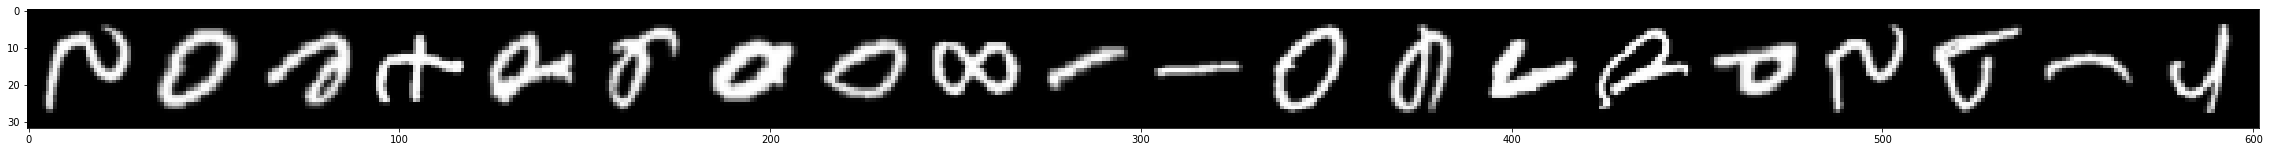

In [4]:
print(train_set.train_labels.bincount())
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images, nrow=20)
plt.figure(figsize=(40,40))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)
print(images.shape)

 <h1>STEP 2: Build the model
 
---


In [101]:
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)   # I: 1x28x28  O: 10x26x26   
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3)  # I: 10x26x26 O: 10x24x24
        
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)   # I: 10x12x12 O: 20x10x10
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3)  # I: 20x10x10 O: 20x8x8
        
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3)   # I: 20x4x4   O: 30x2x2
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=100, kernel_size=1)  # I: 30x2x2   O: 100x2x2
        
        self.out = nn.AvgPool2d(2,2)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        
        # max Pooling after conv1 and conv2
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)

        # (5) hidden conv layer
        t = self.conv4(t)
        t = F.relu(t)
        
        # max Pooling after conv3 and conv4
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (6) hidden conv layer
        t = self.conv5(t)
        t = F.relu(t)

        # (7) hidden conv 1x1 layer (ANTMAN to reduce channels from 30 to 10)
        t = self.conv6(t)
        
        # (8) Global Average Pooling
        t = self.out(t)
        t = torch.squeeze(t)
        return t

In [108]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('device is', use_cuda)
network = Network().to(device)
summary(network, input_size=(1, 28, 28))

device is True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
            Conv2d-2           [-1, 10, 24, 24]             910
            Conv2d-3           [-1, 20, 10, 10]           1,820
            Conv2d-4             [-1, 20, 8, 8]           3,620
            Conv2d-5             [-1, 30, 2, 2]           5,430
            Conv2d-6            [-1, 100, 2, 2]           3,100
         AvgPool2d-7            [-1, 100, 1, 1]               0
Total params: 14,980
Trainable params: 14,980
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.06
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


 <h1>STEP 3: Train the model
 
---


In [52]:
import torch.optim as optim

torch.set_grad_enabled(True)

In [104]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [110]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(20):

    total_loss = 0
    total_correct = 0
    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

    for images, labels in train_loader:  # Get Batch
        images, labels = images.to(device), labels.to(device)
        preds = network(images) # Pass Batch
        # preds = torch.squeeze(preds.int())

        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )


epoch 0 total_correct: 0 loss: 0
epoch 0 total_correct: 534391 loss: 5061.490548893809
epoch 1 total_correct: 0 loss: 0
epoch 1 total_correct: 558489 loss: 4142.094499975443
epoch 2 total_correct: 0 loss: 0
epoch 2 total_correct: 562311 loss: 4004.4318518191576
epoch 3 total_correct: 0 loss: 0
epoch 3 total_correct: 564022 loss: 3934.8901328593493
epoch 4 total_correct: 0 loss: 0
epoch 4 total_correct: 565682 loss: 3879.0365351736546
epoch 5 total_correct: 0 loss: 0
epoch 5 total_correct: 566621 loss: 3852.495453104377
epoch 6 total_correct: 0 loss: 0
epoch 6 total_correct: 566883 loss: 3832.6214144080877
epoch 7 total_correct: 0 loss: 0
epoch 7 total_correct: 566929 loss: 3834.8807761222124
epoch 8 total_correct: 0 loss: 0
epoch 8 total_correct: 567285 loss: 3822.1638595461845
epoch 9 total_correct: 0 loss: 0
epoch 9 total_correct: 567502 loss: 3827.147940069437
epoch 10 total_correct: 0 loss: 0
epoch 10 total_correct: 567863 loss: 3818.7956908792257
epoch 11 total_correct: 0 loss: 0
